In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from keras import optimizers

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix

Load data

In [2]:
from sklearn.model_selection import train_test_split
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")



X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)
X_train shape: (40000, 32, 32, 3)
y_train shape: (40000, 1)
X_val shape: (10000, 32, 32, 3)
y_val shape: (10000, 1)


Viusualdefsknjdfajksbjksa

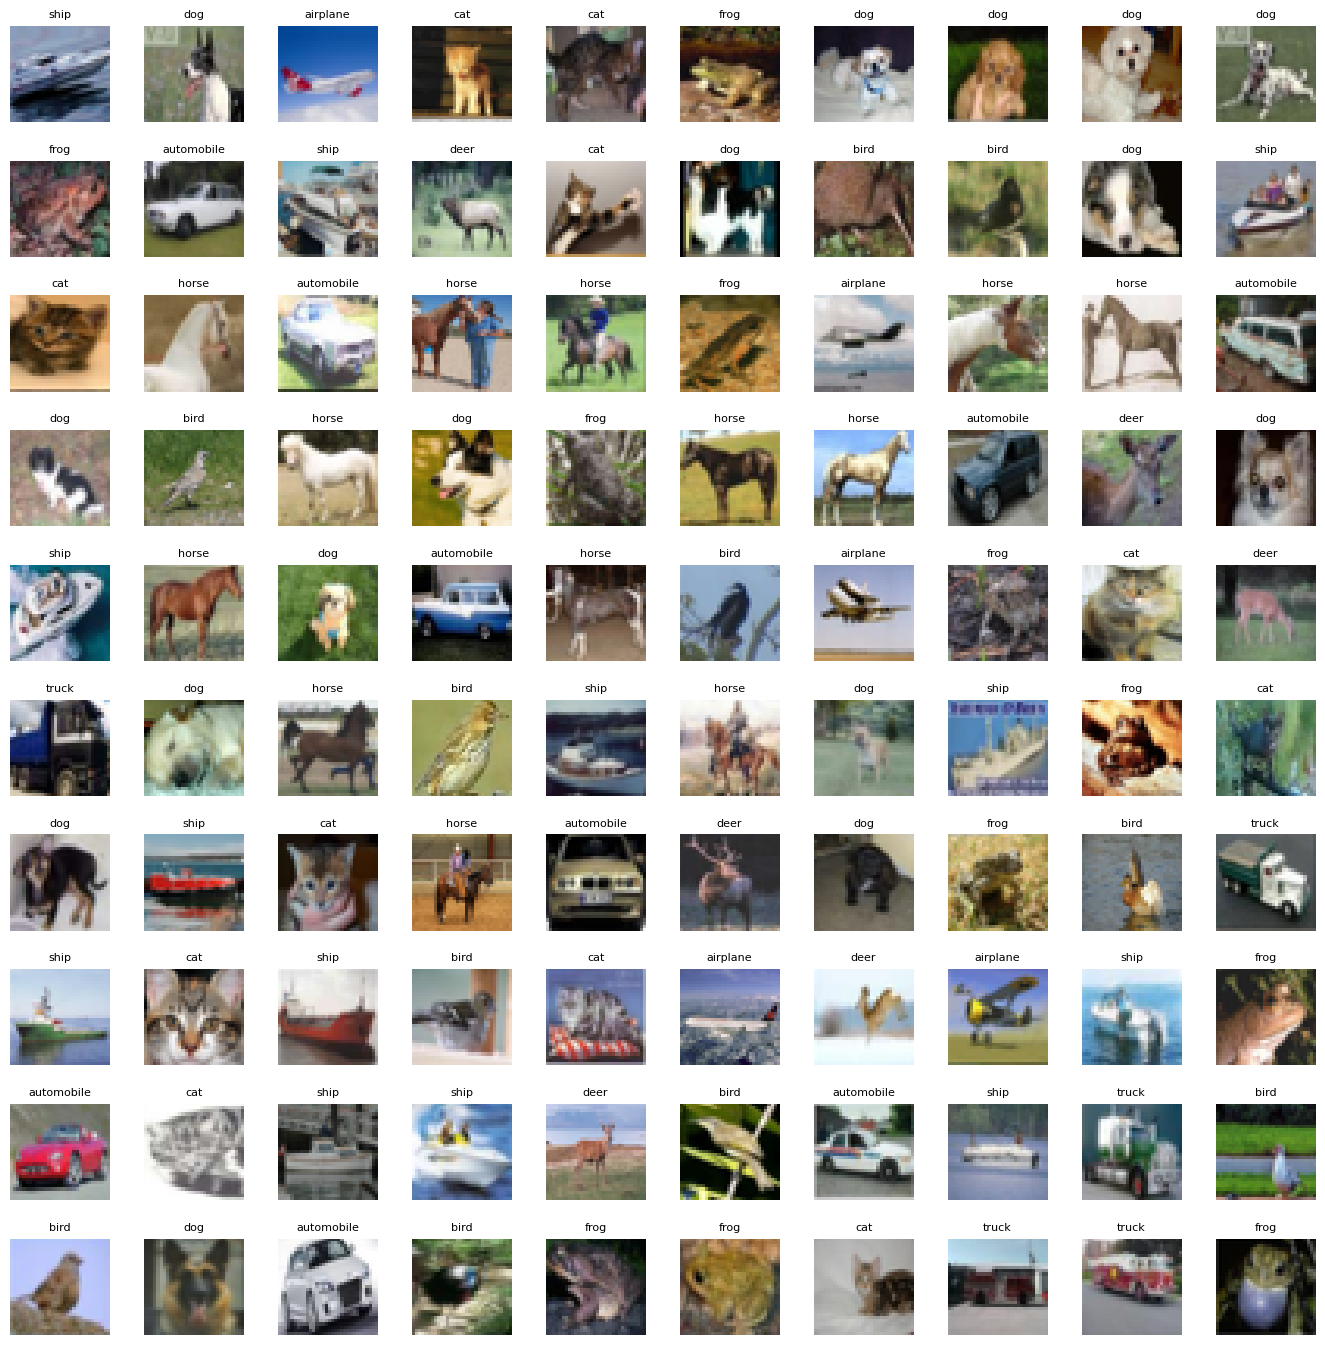

In [3]:
# Define the labels of the dataset
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
          'dog', 'frog', 'horse', 'ship', 'truck']

# Let's view more images in a grid format
# Define the dimensions of the plot grid
W_grid = 10
L_grid = 10

# fig, axes = plt.subplots(L_grid, W_grid)
# subplot return the figure object and axes object
# we can use the axes object to plot specific figures at various locations

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))

axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array

n_train = len(X_train) # get the length of the train dataset

# Select a random number from 0 to n_train
for i in np.arange(0, W_grid * L_grid): # create evenly spaces variables

    # Select a random number
    index = np.random.randint(0, n_train)
    # read and display an image with the selected index
    axes[i].imshow(X_train[index,1:])
    label_index = int(y_train[index])
    axes[i].set_title(labels[label_index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

Text(0.5, 1.0, 'Class distribution in training set')

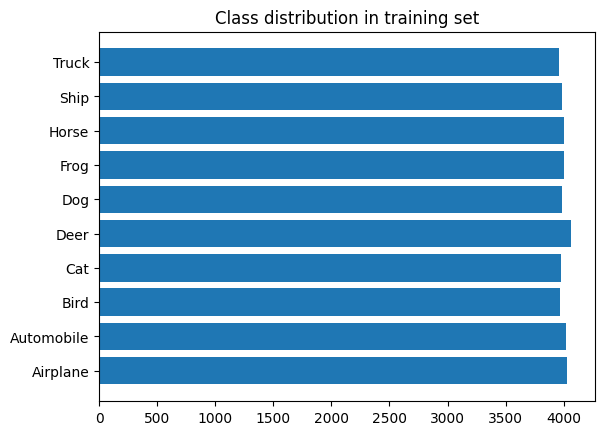

In [4]:
classes_name = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

classes, counts = np.unique(y_train, return_counts=True)
plt.barh(classes_name, counts)
plt.title('Class distribution in training set')


Text(0.5, 1.0, 'Class distribution in testing set')

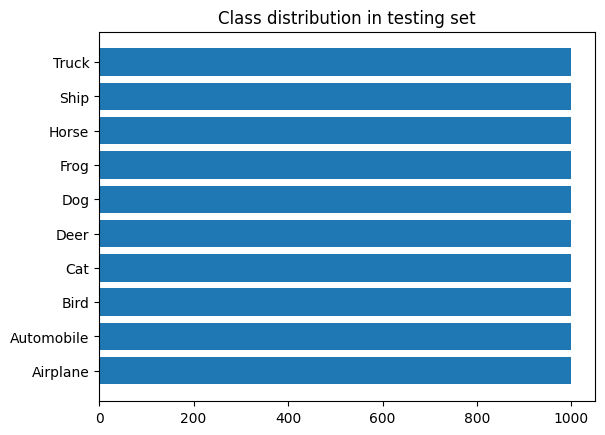

In [5]:
classes, counts = np.unique(y_test, return_counts=True)
plt.barh(classes_name, counts)
plt.title('Class distribution in testing set')

Data Perpocessing

In [6]:
# Scale the data
X_train = X_train / 255.0
X_test = X_test / 255.0

# Transform target variable into one-hotencoding
y_cat_train = to_categorical(y_train, 10)
y_cat_test = to_categorical(y_test, 10)

#y_bird_train = to_categorical(y_train, 10)
#y_bird_test = to_categorical(y_test, 10)

In [43]:
y_cat_train


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

AlexNet

In [7]:
print(X_train.shape)  # Should display (num_samples, width, height, num_channels)
print(y_train.shape)  # Should display (num_samples, num_classes)

print(X_val.shape)    # Should display (num_samples, width, height, num_channels)
print(y_val.shape)    # Should display (num_samples, num_classes)


(40000, 32, 32, 3)
(40000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [8]:
from keras import backend as K
from keras.layers import Layer

class LRN(Layer):
    def __init__(self, alpha=1e-4, beta=0.75, k=2, n=5, **kwargs):
        self.alpha = alpha
        self.beta = beta
        self.k = k
        self.n = n
        super(LRN, self).__init__(**kwargs)

    def build(self, input_shape):
        self.shape = input_shape
        super(LRN, self).build(input_shape)

    def call(self, x, mask=None):
        squared = K.square(x)
        pooled = K.pool2d(squared, (self.n, self.n), strides=(1, 1), padding='same', pool_mode='avg')
        summed = K.sum(pooled, axis=1, keepdims=True)
        averaged = self.alpha * K.repeat_elements(summed, self.shape[1], axis=1)
        denom = K.pow(self.k + averaged, self.beta)
        return x / denom

    def compute_output_shape(self, input_shape):
        return input_shape

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization

INPUT_SHAPE = (32, 32, 3)  # Assuming your input shape is 32x32 pixels with 3 color channels
NUM_CLASSES = 10  # Assuming you have 10 output classes

model = Sequential()

# 1st Convolutional Layer
model.add(Conv2D(96, (3, 3), input_shape=INPUT_SHAPE, strides=(1, 1), padding='same'))
model.add(Activation('relu'))
#addd my LRN
model.add(LRN())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
model.add(BatchNormalization())

# 2nd Convolutional Layer
model.add(Conv2D(256, (3, 3), strides=(1, 1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
model.add(BatchNormalization())

# 3rd Convolutional Layer
model.add(Conv2D(384, (3, 3), strides=(1, 1), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

# 4th Convolutional Layer
model.add(Conv2D(384, (3, 3), strides=(1, 1), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

# 5th Convolutional Layer
model.add(Conv2D(256, (3, 3), strides=(1, 1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
model.add(BatchNormalization())

model.add(Flatten())

# 1st Dense Layer
model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())

# 2nd Dense Layer
model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())

# Output Layer
model.add(Dense(NUM_CLASSES))
model.add(Activation('softmax'))

#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.Precision()])
METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=METRICS)
# Compile the model for optimizer comparison

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 96)        2688      
                                                                 
 activation (Activation)     (None, 32, 32, 96)        0         
                                                                 
 lrn (LRN)                   (None, 32, 32, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 96)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 16, 16, 96)        384       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 256)       2

In [13]:
#INPUT_SHAPE = (32, 32, 3)
#KERNEL_SIZE = (3, 3)
#model = Sequential()

# Convolutional Layer
#model.add(Conv2D(filters=32, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
#model.add(BatchNormalization())
#model.add(Conv2D(filters=32, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
#model.add(BatchNormalization())
# Pooling layer
#model.add(MaxPool2D(pool_size=(2, 2)))
# Dropout layers
#model.add(Dropout(0.25))

#model.add(Conv2D(filters=64, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
#model.add(BatchNormalization())
#model.add(Conv2D(filters=64, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
#model.add(BatchNormalization())
#model.add(MaxPool2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

#model.add(Conv2D(filters=128, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
#model.add(BatchNormalization())
#model.add(Conv2D(filters=128, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
#model.add(BatchNormalization())
#model.add(MaxPool2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

#model.add(Flatten())
# model.add(Dropout(0.2))
#model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.25))
#model.add(Dense(10, activation='softmax'))

#METRICS = [
#    'accuracy',
#    tf.keras.metrics.Precision(name='precision'),
#    tf.keras.metrics.Recall(name='recall')
#]
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=METRICS)

In [10]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [11]:
batch_size = 32
data_generator = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train_generator = data_generator.flow(X_train, y_cat_train, batch_size)
steps_per_epoch = X_train.shape[0] // batch_size

r = model.fit(train_generator,
              epochs=5,
              steps_per_epoch=steps_per_epoch,
              validation_data=(X_test, y_cat_test),
#               callbacks=[early_stop],
#               batch_size=batch_size,
             )

Epoch 1/5
1250/1250 [==============================] - 64s 35ms/step - loss: 2.0783 - accuracy: 0.3697 - precision: 0.4446 - recall: 0.2726 - val_loss: 1.7410 - val_accuracy: 0.4568 - val_precision: 0.5401 - val_recall: 0.3639
Epoch 2/5
1250/1250 [==============================] - 43s 34ms/step - loss: 1.5042 - accuracy: 0.5197 - precision: 0.6055 - recall: 0.4308 - val_loss: 2.6205 - val_accuracy: 0.4598 - val_precision: 0.5213 - val_recall: 0.4088
Epoch 3/5
1250/1250 [==============================] - 43s 34ms/step - loss: 1.2647 - accuracy: 0.5949 - precision: 0.6786 - recall: 0.5152 - val_loss: 1.4168 - val_accuracy: 0.5573 - val_precision: 0.6614 - val_recall: 0.4655
Epoch 4/5
1250/1250 [==============================] - 44s 35ms/step - loss: 1.1397 - accuracy: 0.6316 - precision: 0.7129 - recall: 0.5588 - val_loss: 1.4108 - val_accuracy: 0.5497 - val_precision: 0.6488 - val_recall: 0.4647
Epoch 5/5
1250/1250 [==============================] - 43s 34ms/step - loss: 1.0247 - accura

In [15]:
# Load data, split the dataset, and preprocess
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Preprocess the data
X_train = X_train / 255.0
X_test = X_test / 255.0
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Define the optimizers to compare
optimizers = {
    'SGD': tf.keras.optimizers.SGD(),  #runs
    'RMSprop': tf.keras.optimizers.RMSprop(),  #runs
    'adam': tf.keras.optimizers.Adam(),   #runs everything bellow might crash it
    'adamW': tf.keras.optimizers.AdamW(),
    'Adadelta': tf.keras.optimizers.Adadelta(),
    'Adagrad': tf.keras.optimizers.Adagrad(),
    'Adamax': tf.keras.optimizers.Adamax(),
    'Adafactor': tf.keras.optimizers.Adafactor(),
    'Nadam': tf.keras.optimizers.Nadam(),
    'Ftrl': tf.keras.optimizers.Ftrl()
}



results = {}

# Create and train models with different optimizers
for name, optimizer in optimizers.items():
    model.optimizer = optimizer  # Set the model's optimizer to the current one
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))
    results[name] = history

# Analyze the performance
for name, history in results.items():
    print(f"Optimizer: {name}")
    print("Training accuracy:", history.history['accuracy'])
    print("Validation accuracy:", history.history['val_accuracy'])

# Use the best optimizer for further operations
best_optimizer = max(results, key=lambda k: results[k].history['val_accuracy'][-1])
print(f"The best optimizer is {best_optimizer}.")

# Summary of the model
model.summary()



Epoch 1/10
 281/1250 [=====>........................] - ETA: 12s - loss: 0.0815 - accuracy: 0.9713 - precision: 0.9740 - recall: 0.9703

KeyboardInterrupt: ignored

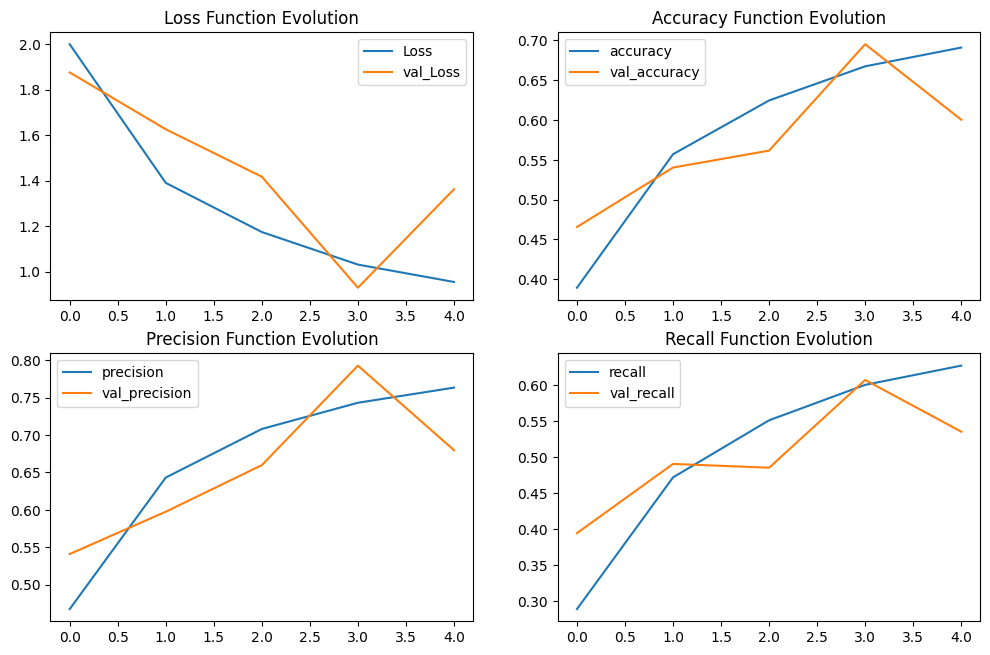

In [16]:
plt.figure(figsize=(12, 16))

plt.subplot(4, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='val_Loss')
plt.title('Loss Function Evolution')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy Function Evolution')
plt.legend()

plt.subplot(4, 2, 3)
plt.plot(r.history['precision'], label='precision')
plt.plot(r.history['val_precision'], label='val_precision')
plt.title('Precision Function Evolution')
plt.legend()

plt.subplot(4, 2, 4)
plt.plot(r.history['recall'], label='recall')
plt.plot(r.history['val_recall'], label='val_recall')
plt.title('Recall Function Evolution')
plt.legend()


313/313 [==============================] - 2s 6ms/step - loss: 1.3619 - accuracy: 0.6003 - precision: 0.6798 - recall: 0.5355
Test Accuracy : 60.03%
313/313 [==============================] - 1s 4ms/step


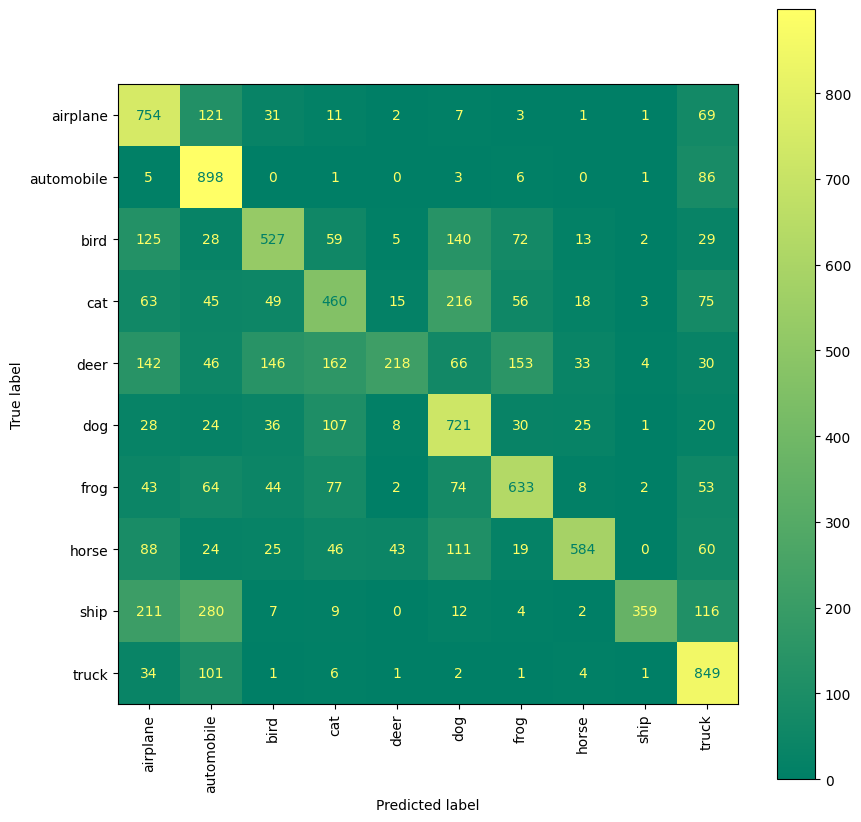

In [17]:
evaluation = model.evaluate(X_test, y_cat_test)
print(f'Test Accuracy : {evaluation[1] * 100:.2f}%')

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred)


disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)


# NOTE: Fill all variables here with default values of the plot_confusion_matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation='vertical', ax=ax,cmap='summer')

plt.show()

In [18]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.51      0.75      0.60      1000
           1       0.55      0.90      0.68      1000
           2       0.61      0.53      0.56      1000
           3       0.49      0.46      0.47      1000
           4       0.74      0.22      0.34      1000
           5       0.53      0.72      0.61      1000
           6       0.65      0.63      0.64      1000
           7       0.85      0.58      0.69      1000
           8       0.96      0.36      0.52      1000
           9       0.61      0.85      0.71      1000

    accuracy                           0.60     10000
   macro avg       0.65      0.60      0.58     10000
weighted avg       0.65      0.60      0.58     10000



Test image

 Image 100 is [4]
1/1 [==============================] - 0s 118ms/step
The model predict that image 100 is 5


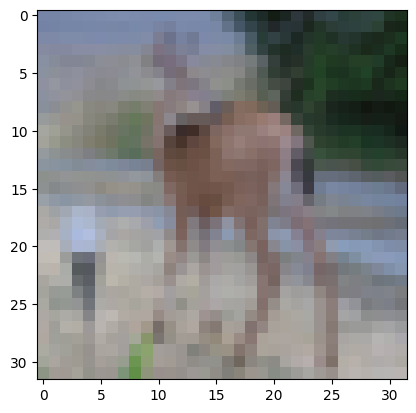

In [19]:
my_image = X_test[100]
plt.imshow(my_image)

# that's a Deer
print(f" Image 100 is {y_test[100]}")

# correctly predicted as a Deer
pred_100 = np.argmax(model.predict(my_image.reshape(1, 32, 32, 3)))
print(f"The model predict that image 100 is {pred_100}")

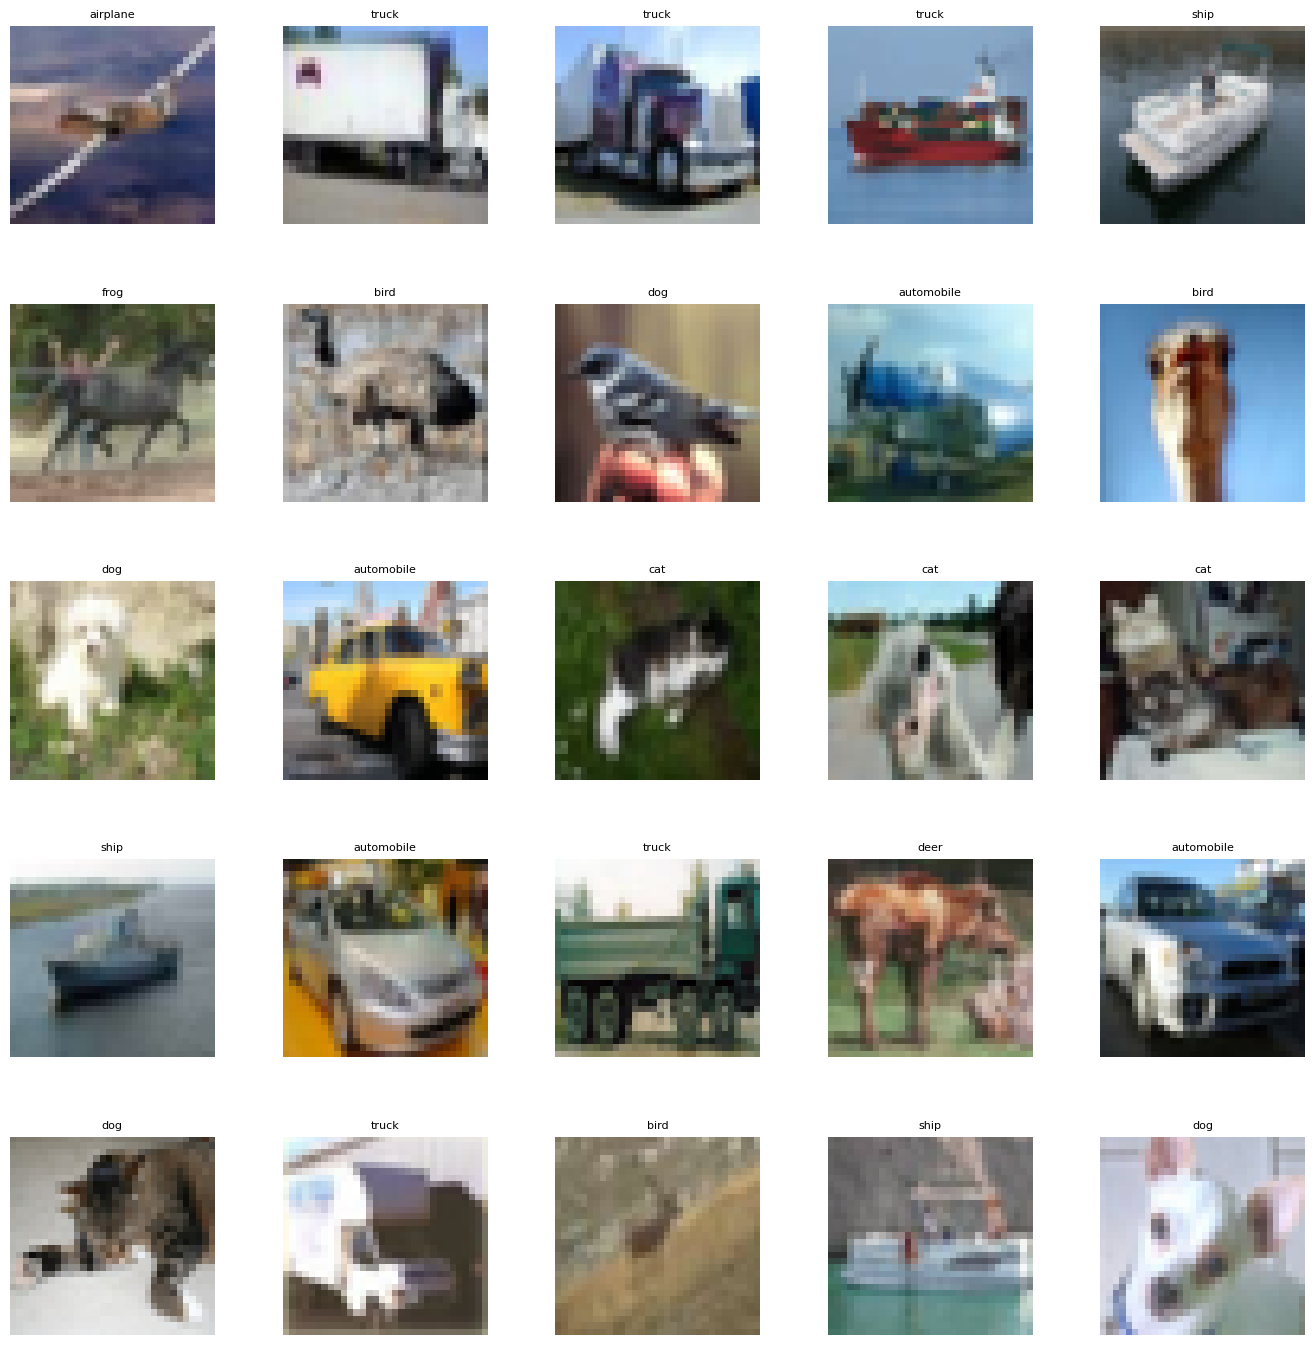

In [20]:
# Define the labels of the dataset
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
          'dog', 'frog', 'horse', 'ship', 'truck']

# Let's view more images in a grid format
# Define the dimensions of the plot grid
W_grid = 5
L_grid = 5

# fig, axes = plt.subplots(L_grid, W_grid)
# subplot return the figure object and axes object
# we can use the axes object to plot specific figures at various locations

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))

axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array

n_test = len(X_test) # get the length of the train dataset

# Select a random number from 0 to n_train
for i in np.arange(0, W_grid * L_grid): # create evenly spaces variables

    # Select a random number
    index = np.random.randint(0, n_test)
    # read and display an image with the selected index
    axes[i].imshow(X_test[index,1:])
    label_index = int(y_pred[index])
    axes[i].set_title(labels[label_index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

In [21]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel(f"{labels[int(predicted_label)]} {100*np.max(predictions_array):2.0f}% ({labels[int(true_label)]})",
               color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, int(true_label[i])
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

313/313 [==============================] - 2s 7ms/step


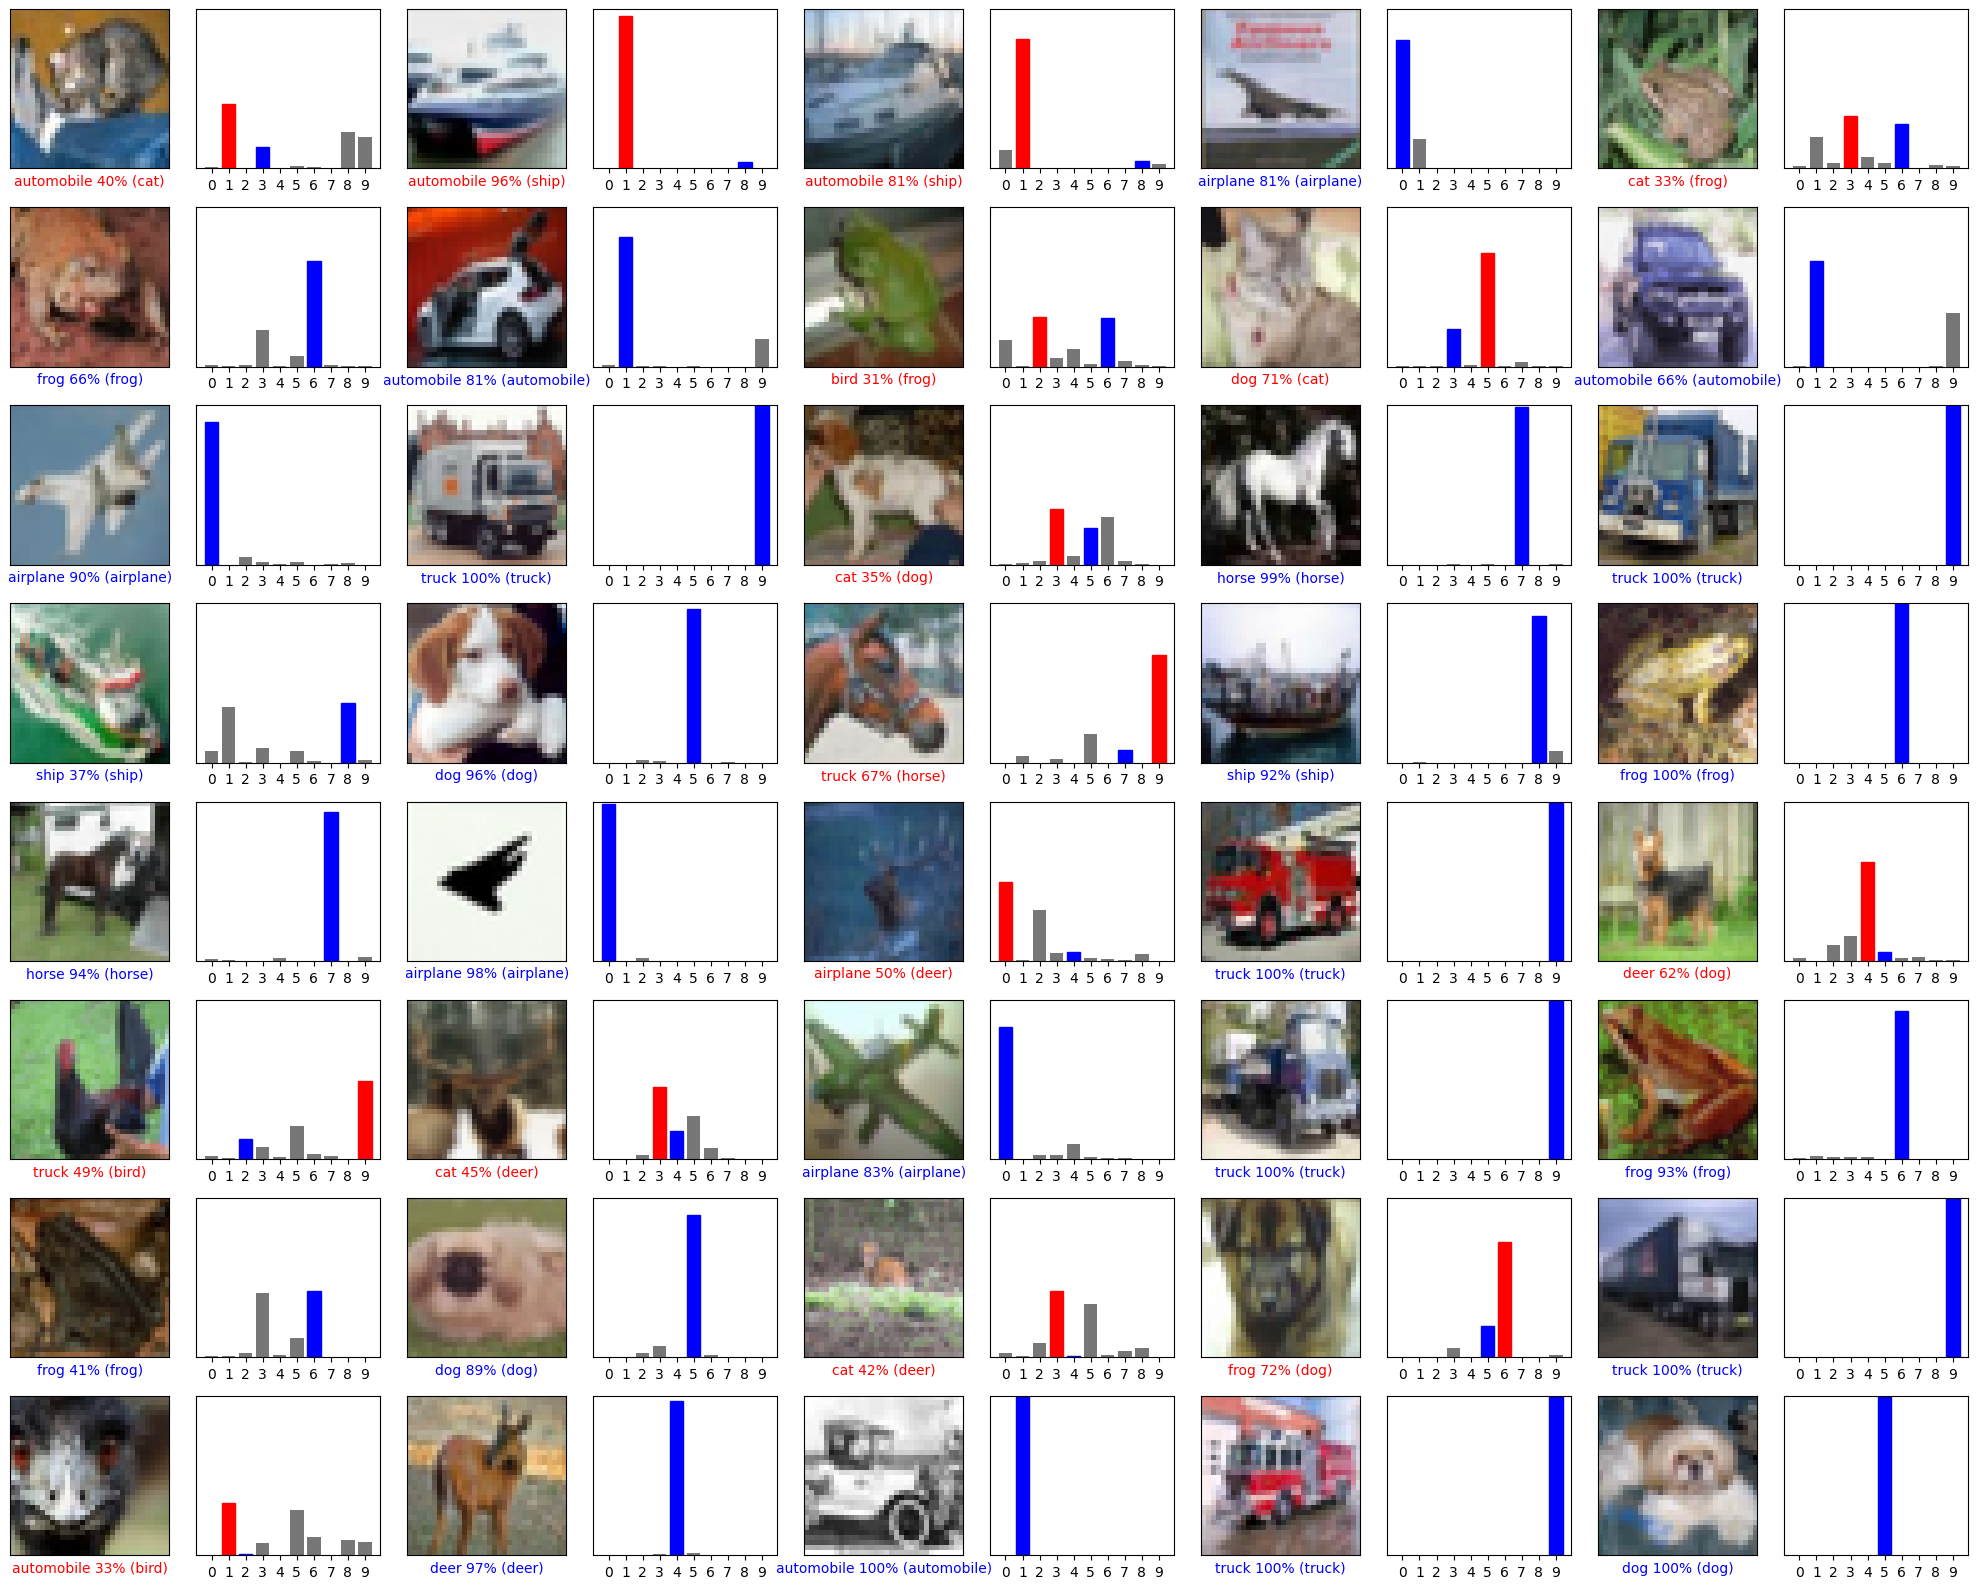

In [22]:
predictions = model.predict(X_test)

# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 8
num_cols = 5
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plot_image(i, predictions[i], y_test, X_test)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], y_test)
plt.tight_layout()
plt.show()

Save CNN

In [ ]:
from tensorflow.keras.models import load_model

model.save('alexNet-50Epochs.h5')